## (подэксперимент D)

Так как в этом эксперименте мы обучали модель напрямую предсказывать метки интересности,
можно просто взять WrapperNet в качестве бейзлайна

Начало этого блокнота похоже на начало блокноота booster.ipynb

Данные можно взять тут: https://disk.yandex.ru/d/q1G0W-taR0TSxw

In [3]:
import pandas as pd

data = pd.read_csv('D:/Program Files/JupyterLabWorkspace/chess_data/full_labeled.csv')
data.head()

,id,white_elo,black_elo,moves,marks
0,787zsVup,1638.0,1851.0,e2e4 c7c6 f2f4 d7d5 e4d5 c6d5 g1f3 b8c6 d2d3 g...,"47,53"
1,F8M8OS71,1760.0,1823.0,e2e4 c7c5 g1f3 d7d6 c2c3 g8f6 d2d3 a7a6 b1d2 e...,"52,56"
2,MQSyb3KW,1877.0,1909.0,e2e4 c7c5 c2c3 d7d6 d2d4 c5d4 c3d4 b7b6 b1c3 c...,"126,130"
3,4MWQCxQ6,1741.0,1625.0,e2e4 e7e5 d2d3 b8c6 g1f3 f8c5 f1e2 g8f6 e1g1 e...,"31,35"
4,e9AY2m5j,1766.0,1733.0,e2e4 c7c5 f1c4 e7e6 g1f3 d7d5 e4d5 e6d5 c4b5 b...,"49,55"


In [4]:
import chess
import numpy as np
import pandas as pd
from typing import Union

def prepare_data(data: Union[pd.DataFrame, dict, pd.Series], wrapper) -> tuple:
    """
    Обрабатывает данные для модели, принимая как DataFrame, так и отдельные записи.

    Args:
        data: Входные данные - DataFrame или отдельная запись (dict/Series)
        board2vec: Функция кодирования досок

    Returns:
        Кортеж (признаки, целевая_переменная)
    """
    # Преобразуем одиночные записи в DataFrame
    if not isinstance(data, pd.DataFrame):
        data = pd.DataFrame([data] if not isinstance(data, list) else data)

    data = data.copy()
    data['moves'] = data['moves'].str.split(' ')
    data['marks'] = data['marks'].str.split(',')
    y_preds = []
    targets = []
    for row in data.itertuples(index=False):
        # Извлекаем параметры из строки
        start, end = map(int, row.marks)
        board = chess.Board()
        boards = []
        target = np.zeros(shape=(len(row.moves),))
        target[start:end] = 1

        # Генерируем последовательность досок и целевых значений
        for move in row.moves:
            board.push(chess.Move.from_uci(move))
            boards.append(board.copy())

        # Кодируем доски и формируем DataFrame
        y_pred = wrapper(boards)
        y_preds.append(y_pred)
        targets.append(target)

    # Объединяем все данные
    y_preds = np.concatenate(y_preds, axis=0)
    targets = np.concatenate(targets, axis=0)

    return y_preds, targets

In [5]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

def validate(y_pred, y_true):
    # Оцениваем качество модели
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Выводим метрики качества
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)


In [6]:
# Муть с относительными импортами
import sys
from pathlib import Path
module_path = str(Path.cwd().parent.parent)
if module_path not in sys.path:
    sys.path.append(module_path)
from experiments.experiment_04.inference import is_interesting

y_pred, y_true = prepare_data(data.sample(300, random_state=42), is_interesting)
print(y_pred.shape, y_true.shape)

D:\Program Files\JupyterLabWorkspace\heuristic_extractor\board2vec\experiments\experiment_04\inference.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  wrapper.load_stat

(28197,) (28197,)


In [7]:
validate(y_pred > 0.3, y_true)

Accuracy: 0.9499
Precision: 0.4625
Recall: 0.0263
F1 Score: 0.0498
Confusion Matrix:
[[26748    43]
 [ 1369    37]]


Неплохо, давайте посмотрим, как именно выглядят предсказания модели

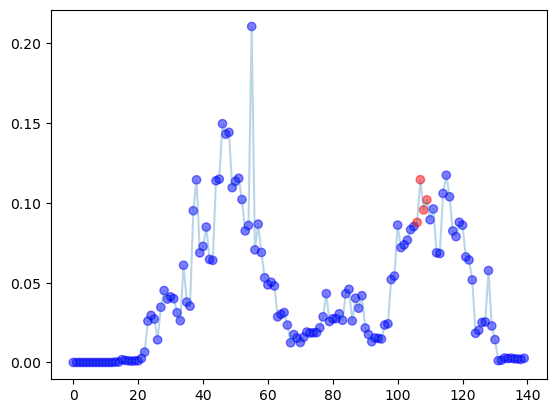

In [26]:
import matplotlib.pyplot as plt

y_pred, y_true = prepare_data(data.sample(1), is_interesting)
plt.scatter(x=np.arange(y_pred.shape[0]), y=y_pred, c=y_true, cmap='bwr', alpha=0.5)
plt.plot(y_pred, alpha=0.3)
plt.show()

Честно говоря, мне больше понравилось как это делает бустер, потому что в данном случае я не вижу чёткой закономерности между интересным моментом и графиком вероятностей интересности ходов.

Возможно модели Board2Vec не хватает слоёв для выделения более сложных паттернов.

## (подэксперимент E)

Итак, я сделал архитектуру посложнее и обучил модель. Спустя 50 эпох я получил примерно то же качество. Теперь мне больше нравится, как модель строит график вероятностей интерсности, поэтому можно посмотреть, как этот результат может улучшить постобработка

In [13]:
# from scipy.signal import find_peaks
# from scipy.signal import peak_widths


# def pseudo_inference(sample: pd.DataFrame, embedding_function, show = False, log = False):
#     y_pred, y_true = prepare_data(sample, embedding_function)

#     # Применяем сглаживание с помощью свёртки
#     kernel = np.ones(5) / 5
#     smoothed = np.convolve(y_pred, kernel, mode='same')
    
#     threshold = np.percentile(smoothed, 70)
#     peaks, _ = find_peaks(smoothed, height=threshold, distance=10)
#     mins, _ = find_peaks(-smoothed, height=-threshold, distance=10)

#     # Проверяем первый элемент
#     if len(smoothed) > 1 and smoothed[0] < smoothed[1]:
#         mins = np.append(mins, 0)
    
#     # Проверяем последний элемент
#     if len(smoothed) > 1 and smoothed[-1] < smoothed[-2]:
#         mins = np.append(mins, len(smoothed) - 1)
    
#     mins = np.sort(mins)
#     # Создание маски
#     y_result = np.zeros_like(smoothed, dtype=int)

#     for peak in peaks:
#         # Поиск ближайших минимумов слева и справа
#         idx = bisect.bisect_left(mins, peak)
#         left = mins[idx-1] if idx > 0 else None
#         right = mins[idx] if idx < len(mins) else None
        
#         if left is not None and right is not None:
#             # Отмечаем интервал [left, right] на маске
#             left = int(left + (peak - left) * 0.1)
#             right = int(right + (right - peak) * 0.1)
#             y_result[left:right+1] = 1

#     if show:
#         plt.scatter(x=np.arange(y_pred.shape[0]), y=y_result, c=y_true, cmap='bwr')
#         plt.scatter(x=np.arange(y_pred.shape[0]), y=y_pred, alpha=0.8, c='k')
#         plt.show()
#     # if log:
#     #     def lol(x):
#     #         kek = x // 2 + 1
#     #         c = 'W' if x % 2 == 0 else 'B'
#     #         return str(kek) + c
#     #     for l, r in zip(left_bounds, right_bounds):
#     #         print(f'[{lol(l)}, {lol(r)}]', end='; ')
#         # print()
#     return y_result, y_true, y_result

from scipy.signal import find_peaks
from scipy.signal import peak_widths


def pseudo_inference(sample: pd.DataFrame, embedding_function, show = False, log = False):
    y_pred, y_true = prepare_data(sample, embedding_function)

    # Применяем сглаживание с помощью свёртки
    kernel = np.ones(5) / 5
    smoothed = np.convolve(y_pred, kernel, mode='same')

    threshold = np.percentile(smoothed, 70)
    peaks, _ = find_peaks(smoothed, height=threshold, distance=10)

    rel_heights = np.minimum(1, smoothed[peaks] * 8)
    widths_list, left_ips_list, right_ips_list = [], [], []

    # Вызываем peak_widths отдельно для каждого пика
    for i, peak in enumerate(peaks):
        w, _, l, r = peak_widths(smoothed, [peak], rel_height=rel_heights[i])

        # Добавляем значения в списки (они массивы, поэтому берем [0])
        widths_list.append(w[0])
        left_ips_list.append(l[0])
        right_ips_list.append(r[0])

    # Преобразуем списки в numpy-массивы (для удобства)
    widths = np.array(widths_list)
    left_ips = np.array(left_ips_list)
    right_ips = np.array(right_ips_list)

    valid_mask = (widths > 4) & (widths < 50)

    # Применяем маску ко всем связанным массивам
    left_ips = left_ips[valid_mask]
    right_ips = right_ips[valid_mask]

    y_result = np.zeros_like(y_pred)

    # Векторное обновление значений в y_result
    left_bounds = np.floor(left_ips).astype(int)
    right_bounds = np.ceil(right_ips).astype(int) + 1

    for start, end in zip(left_bounds, right_bounds):
        y_result[start:end] = 1

    if show:
        plt.scatter(x=np.arange(y_pred.shape[0]), y=y_result, c=y_true, cmap='bwr')
        plt.scatter(x=np.arange(y_pred.shape[0]), y=y_pred, alpha=0.8, c='k')
        plt.show()
    if log:
        def lol(x):
            kek = x // 2 + 1
            c = 'W' if x % 2 == 0 else 'B'
            return str(kek) + c
        for l, r in zip(left_bounds, right_bounds):
            print(f'[{lol(l)}, {lol(r)}]', end='; ')
        print()
    return y_result, y_true, y_result

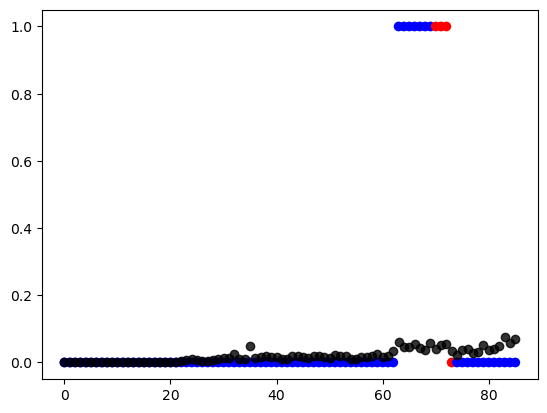

In [33]:
example = data.sample(1)
_ = pseudo_inference(example, is_interesting, show=True)

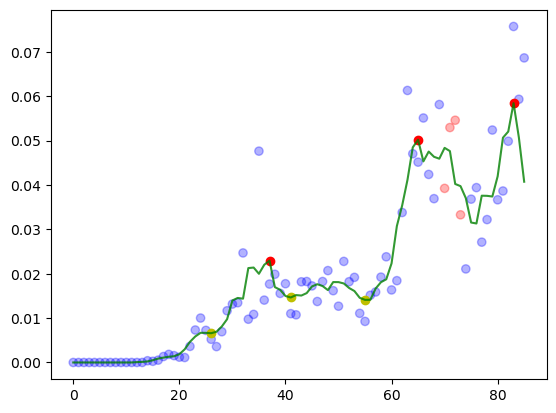

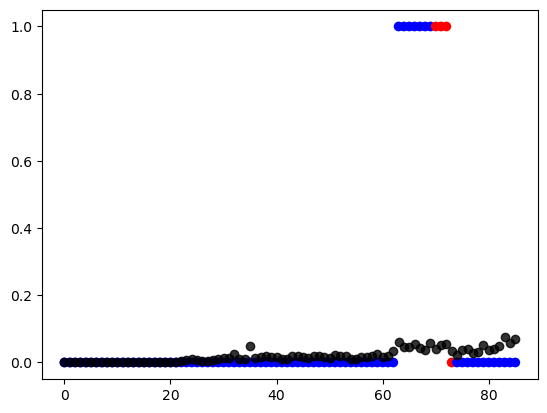

In [35]:
from scipy.signal import find_peaks
from scipy.signal import peak_widths
import bisect

y_pred, y_true = prepare_data(example, is_interesting)

# Применяем сглаживание с помощью свёртки
kernel = np.ones(5) / 5
smoothed = np.convolve(y_pred, kernel, mode='same')

threshold = np.percentile(smoothed, 70)
peaks, _ = find_peaks(smoothed, height=threshold, distance=10)
mins, _ = find_peaks(-smoothed, height=-threshold, distance=10)
mins = np.sort(mins)

# rel_heights = np.minimum(1, smoothed[peaks] * 8)
# widths_list, left_ips_list, right_ips_list = [], [], []

# # Вызываем peak_widths отдельно для каждого пика
# for i, peak in enumerate(peaks):
#     w, _, l, r = peak_widths(smoothed, [peak], rel_height=rel_heights[i])

#     # Добавляем значения в списки (они массивы, поэтому берем [0])
#     widths_list.append(w[0])
#     left_ips_list.append(l[0])
#     right_ips_list.append(r[0])

# # Преобразуем списки в numpy-массивы (для удобства)
# widths = np.array(widths_list)
# left_ips = np.array(left_ips_list)
# right_ips = np.array(right_ips_list)

# print(widths, left_ips, right_ips)

x = np.arange(len(smoothed))
plt.plot(x[peaks], smoothed[peaks], 'ro', label='Пики')
plt.plot(x[mins], smoothed[mins], 'yo', label='Минимумы')
plt.scatter(x=np.arange(y_pred.shape[0]), y=y_pred, c=y_true, cmap='bwr', alpha=0.3)
plt.plot(smoothed, alpha=0.8, c='green')
plt.show()
_ = pseudo_inference(example, is_interesting, show=True)

In [16]:
precisions = []
recalls = []
for _ in range(250):
    y_pred, y_true, _ = pseudo_inference(data.sample(1), is_interesting)
    precisions.append(precision_score(y_true, y_pred, zero_division=0))
    recalls.append(recall_score(y_true, y_pred))
print(f'Precision: {sum(precisions) / len(precisions):.4f}, Recall: {sum(recalls) / len(recalls):.4f}')

Precision: 0.1030, Recall: 0.4955
